In [21]:
!pip install seaborn
!pip install tqdm
!pip install scikit-learn
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



# PREPROCESO DE LOS DATOS

Iremos leyendo el csv en grupos de 100000 filas, los procesaremos y luego lo juntaremos otra vez

La siguiente función de preproceso hará lo siguiente con cada archivo


1) Vamos a eliminar aquellas columnas que tengan más de un 90% de datos faltantes. Hacemos esto porque son columnas que apenas van a aportar al modelo de clasificación, lo que permite simplificarlo sin perder precisión. 


2) Tratamos con los valores nulos, para ello vemos al usuario, si le falta datos en una columna categórica se pondrá el que más aparece y si es una numérica la media. 



3) Ahora analizamos los datos de tipo categórico. Para ello hemos visto que la columna Expenditure_AHF probablemente no sea muy útil ya que aporta fechas y el dataset no tiene pinta de tener en cuenta el tiempo. 

Luego vemos que las columnas Infraction_CLH, Base_67254 y Infraction_TEN apesar de ser categóricos tienen un significado ordinal, por lo que podemos usar labelEncoding.

Por último las columnas Infraction_YFSG e Infraction_DQLY al no tener un valor ordinal y tener solo pocos valores disponibles, le aplicaremos one-hot-encoding.


4) Haremos un groupby por índice, así tendremos una linea por usuario, para tratar con sus datos, sumaremos los True de las columnas que hemos creado con one-hot-encoding y para el resto simplemento haremos la media.


5) Normalizamos los valores para que le sea más fácil al modelo aprender


Vamos yendo por cada archivo y aplicando la función de preproceso. Al final, volveremos a hacer un groupby por el ID dado que puede darse el caso de que en dos archivos, las líneas del final de uno y las del comienzo del otro compartan el mismo ID.

In [26]:
def preproceso(X):    
    # 1) 
    nulos = X.isnull().sum() >= 0.9*X.shape[0]
    nulos_a_eliminar = nulos[nulos].index
    X.drop(nulos_a_eliminar, axis=1, inplace=True)


    # 2) 
    X_num = X.select_dtypes(include = [np.number])
    X_obj = X.select_dtypes(include = [object])

    aux1 = X_num.isnull().sum() > 0
    X[aux1[aux1].index] = X[aux1[aux1].index].fillna(X[aux1[aux1].index].mean())
    aux2 = X_obj.isnull().sum() > 0
    X[aux2[aux2].index] = X[aux2[aux2].index].fillna(X[aux2[aux2].index].mode())



    # 3) 
    label = ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']
    one_hot = ['Infraction_YFSG', 'Infraction_DQLY']

    X.drop('Expenditure_AHF', axis=1, inplace=True)
    X = pd.get_dummies(X, columns=one_hot)
    le = LabelEncoder()
    for col in label:
        X[col] = le.fit_transform(X[col])


    # 4)
    def f(x):
        if x.dtypes == bool:
            return x.sum()
        else:
            return x.mean()  

    X = X.groupby('ID').agg(f)


    # 5)
    X = (X - X.min()) / (X.max() - X.min())
    return X

In [39]:
cols = pd.read_csv('ML_24_25_PR1_train_and_test/train_data.csv', nrows=1).columns

chunksize = 100000 
X = pd.DataFrame()
for chunk in tqdm(pd.read_csv('ML_24_25_PR1_train_and_test/train_data.csv', skiprows=1, chunksize=chunksize, \
                              header=None), desc="Procesando"):
    chunk.columns = cols
    X_new = preproceso(chunk)
    X = pd.concat([X, X_new])

X = X.groupby('ID').agg('mean')

Procesando: 0it [00:00, ?it/s]

Procesando: 34it [36:59, 65.29s/it]


Los siguientes pasos consistirán en rellenar valores nulos y optimizar los tipos de datos haciendo que ocupen lo menos posible.

In [40]:
y = pd.read_csv('ML_24_25_PR1_train_and_test/train_labels.csv', index_col=['ID'])
df = pd.concat([X, y], axis=1)

aux1 = df.isnull().sum() < 0.9 * df.shape[0]
df[aux1[aux1].index] = df[aux1[aux1].index].fillna(df[aux1[aux1].index].mean())

df = df.apply(pd.to_numeric, downcast='float')

Graficamos el mapa de correlación para poder compararlo luego una vez realizado la selección de característica.

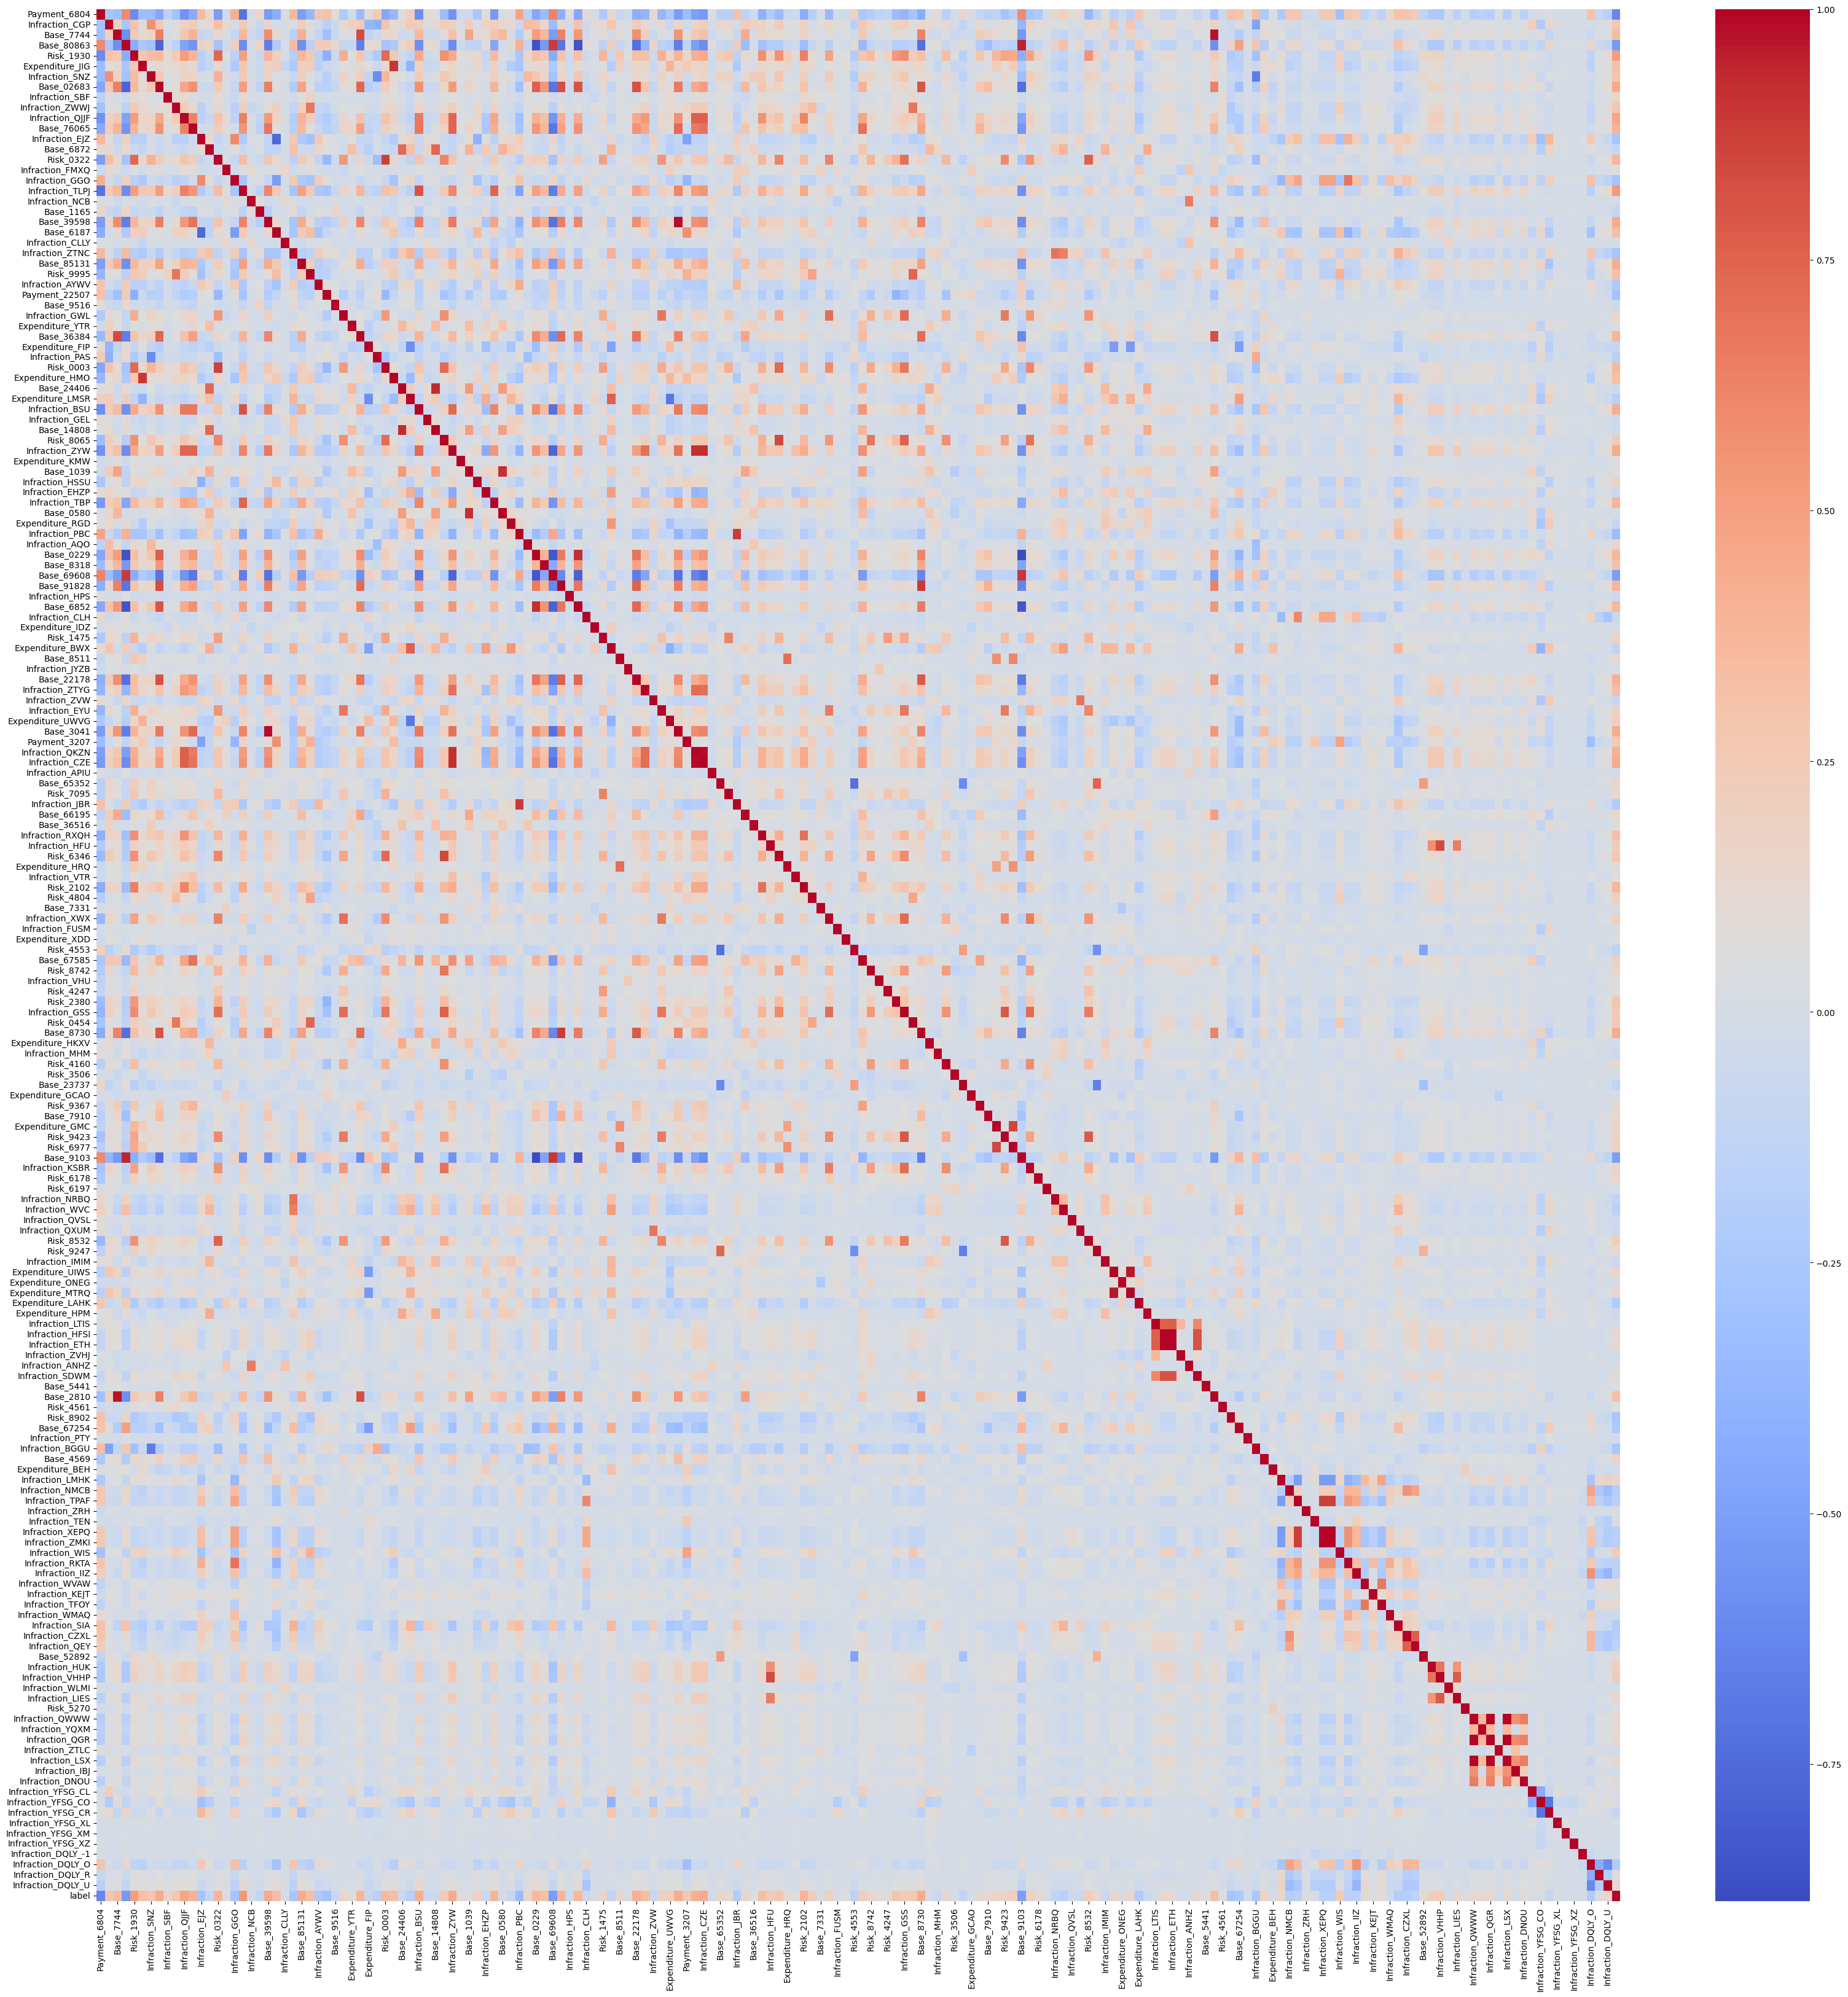

In [41]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

# TRATAMIENTO DE DATOS DESBALANCEADOS

Verificamos si tenemos datos desbalanceados y nos encontramos con una proporción algo mayor que el 1/3. Por ello, realizaremos oversampling con SMOTE para aumentar el número de casos con los datos minoritarios. Mantendremos y trabajaremos con estos dos nuevos datasets y luego veremos cual de los dos nos devuelve mejores resultados.

In [42]:
display(df.label.value_counts())

smote = SMOTE(random_state=42)
X_, y_ = df.drop('label', axis=1), df.label
X_over, y_over = smote.fit_resample(X_, y_)

df_over = pd.concat([X_over, y_over], axis=1)

df_over.label.value_counts()

label
0.0    203889
1.0     71458
Name: count, dtype: int64

label
1.0    203889
0.0    203889
Name: count, dtype: int64

# SELECCIÓN DE CARACTERÍSTICA

Crearemos 4 funciones para seleccionar las columnas importantes.

La primera consistirá en un análisis manual imponiendo umbrales para algunas características como: correlación entre columnas mayor que x, número de NANs en la columna...

El segundo usará métodos del filtro, en específico: VarianceThreshold

El tercero usará métodos de wrapper, en específico usaremos los siguientes modelos:

El cuarto usará métodos de embeddings, en específico:

In [37]:
def FS1(df):
    df_aux = df.copy()
    n = 0
    
    # eliminamos la columna si tiene una correlación alta con otras
    corr = df_aux.corr().fillna(0)
    aux = np.abs(corr) > 0.8
    indices_filas, indices_columnas = np.where(aux)
    parecido_a_eliminar = [corr.columns[col] for row, col in zip(indices_filas, indices_columnas)\
                            if row != col and (row + col) < 2 * row]
    df_aux.drop(parecido_a_eliminar, axis=1, inplace=True)

    # eliminamos la columna si su correlación con la etiqueta es muy baja
    corr = corr['label'].drop(parecido_a_eliminar)
    aux = np.abs(corr) < 0.1
    indices = np.where(aux)
    poco_importante = corr.index[indices]
    df_aux.drop(poco_importante, axis=1, inplace=True)

    # eliminamos las columnas si tienen un valor que represente el 80% de los datos
    sobre_representado_a_eliminar = [col for col in df_aux.columns \
                                     if df_aux[col].value_counts().iloc[0] >= 0.8*df.shape[0]]
    df_aux.drop(sobre_representado_a_eliminar, axis=1, inplace=True)

    n += len(parecido_a_eliminar) + len(poco_importante) + len(sobre_representado_a_eliminar)
    cols_eliminadas = parecido_a_eliminar + poco_importante.tolist() + sobre_representado_a_eliminar

    print(f'Se ha eliminado {n} columnas con métodos de selección manual, específicamente: {cols_eliminadas}')
    return df_aux

df1 = FS1(df)
df1_over = FS1(df_over)

df1.to_csv('df1.csv')
df1_over.to_csv('df1_over.csv')

Se ha eliminado 100 columnas con métodos de selección manual, específicamente: ['Base_7744', 'Risk_0322', 'Expenditure_JIG', 'Infraction_TLPJ', 'Base_24406', 'Base_1039', 'Base_80863', 'Base_80863', 'Base_0229', 'Base_02683', 'Base_80863', 'Base_02683', 'Base_0229', 'Base_02683', 'Base_39598', 'Infraction_ZYW', 'Infraction_ZYW', 'Infraction_QKZN', 'Infraction_PBC', 'Risk_8065', 'Base_02683', 'Base_91828', 'Expenditure_GMC', 'Base_80863', 'Base_0229', 'Base_69608', 'Base_6852', 'Expenditure_UIWS', 'Infraction_HFSI', 'Infraction_HFSI', 'Infraction_ETH', 'Base_7744', 'Base_36384', 'Infraction_TPAF', 'Infraction_TPAF', 'Infraction_XEPQ', 'Infraction_HFU', 'Infraction_QWWW', 'Infraction_QWWW', 'Infraction_QGR', 'Infraction_FMXQ', 'Infraction_NCB', 'Infraction_CLLY', 'Base_9516', 'Expenditure_YTR', 'Expenditure_FIP', 'Infraction_GEL', 'Base_14808', 'Expenditure_KMW', 'Infraction_EHZP', 'Base_0580', 'Expenditure_RGD', 'Infraction_HPS', 'Infraction_CLH', 'Expenditure_IDZ', 'Infraction_JYZB', '

Se ha eliminado 95 columnas con umbral de varianza específicamente: ['Infraction_VTR', 'Expenditure_RGD', 'Infraction_XWX', 'Risk_6346', 'Base_8511', 'Infraction_YFSG_XZ', 'Infraction_CGP', 'Base_85131', 'Risk_1475', 'Infraction_AQO', 'Infraction_NRBQ', 'Infraction_DNOU', 'Infraction_GEL', 'Risk_9247', 'Base_67585', 'Infraction_SBF', 'Infraction_SNZ', 'Infraction_ZVW', 'Infraction_JYZB', 'Infraction_ZTLC', 'Infraction_CZE', 'Base_22178', 'Base_76065', 'Risk_4160', 'Risk_0454', 'Infraction_ZVHJ', 'Infraction_TFOY', 'Expenditure_GMC', 'Risk_4561', 'Base_23737', 'Risk_4804', 'Infraction_GSS', 'Base_36516', 'Risk_9423', 'Base_4569', 'Infraction_QKZN', 'Infraction_NCB', 'Base_24406', 'Infraction_WLMI', 'Risk_6178', 'Risk_8742', 'Expenditure_XDD', 'Infraction_ZTYG', 'Infraction_GWL', 'Infraction_APIU', 'Base_65352', 'Risk_9995', 'Infraction_YFSG_XL', 'Risk_0003', 'Infraction_RXQH', 'Expenditure_GCAO', 'Infraction_FUSM', 'Risk_2102', 'Expenditure_HPM', 'Expenditure_HMO', 'Risk_2380', 'Expendi

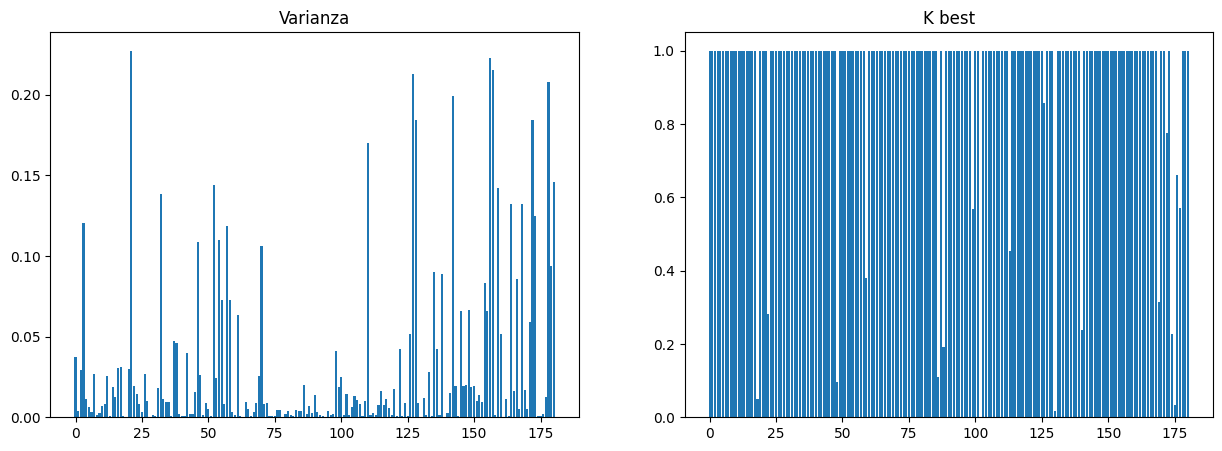

Se ha eliminado 92 columnas con umbral de varianza específicamente: ['Infraction_VTR', 'Expenditure_RGD', 'Infraction_XWX', 'Risk_6346', 'Base_8511', 'Infraction_YFSG_XZ', 'Infraction_CGP', 'Base_85131', 'Risk_1475', 'Infraction_AQO', 'Infraction_NRBQ', 'Infraction_DNOU', 'Infraction_GEL', 'Risk_9247', 'Base_67585', 'Infraction_SBF', 'Infraction_SNZ', 'Infraction_ZVW', 'Infraction_JYZB', 'Infraction_ZTLC', 'Base_76065', 'Risk_4160', 'Risk_0454', 'Infraction_ZVHJ', 'Infraction_TFOY', 'Risk_4561', 'Base_23737', 'Risk_4804', 'Infraction_GSS', 'Base_36516', 'Risk_9423', 'Base_4569', 'Infraction_QKZN', 'Infraction_NCB', 'Base_24406', 'Infraction_WLMI', 'Risk_6178', 'Risk_8742', 'Expenditure_XDD', 'Infraction_ZTYG', 'Infraction_GWL', 'Infraction_APIU', 'Infraction_WVAW', 'Base_65352', 'Risk_9995', 'Infraction_YFSG_XL', 'Infraction_RXQH', 'Expenditure_GCAO', 'Infraction_FUSM', 'Risk_2102', 'Expenditure_HPM', 'Risk_2380', 'Expenditure_KMW', 'Risk_5270', 'Infraction_QXUM', 'Risk_6197', 'Infract

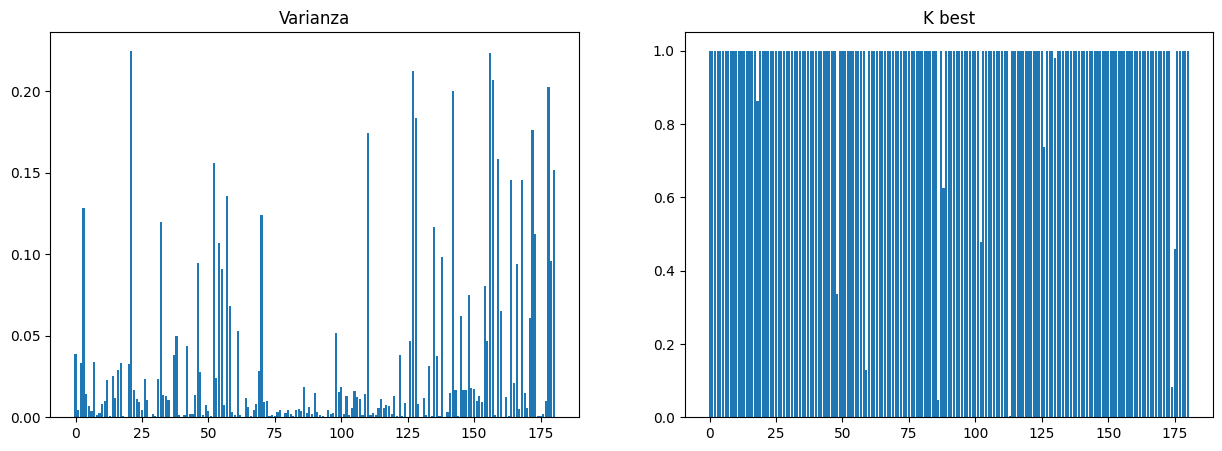

In [38]:
def FS2(df):
    df_aux = df.copy()
    X, y = df_aux.drop('label', axis=1), df_aux['label']
    
    #  Umbral de varianza
    var = VarianceThreshold().fit(X)
    puntuaje1 = var.variances_
    
    df_aux1 = pd.concat([X.loc[:, puntuaje1 > 0.01], y], axis=1)
    print(f'Se ha eliminado {df.shape[1] - df_aux1.shape[1]} columnas con umbral de varianza', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux1.columns))}')


    # Selección de características univariantes con K mejores
    selector = SelectKBest(f_classif).fit(X, y)
    epsilon = 10**(-20)
    puntuaje2 = -np.log10(selector.pvalues_ + epsilon)
    puntuaje2 /= (puntuaje2.max() + epsilon)

    df_aux2 = pd.concat([X.loc[:, puntuaje2 > 0.2], y], axis=1)
    print(f'Se ha eliminado {df.shape[1] - df_aux2.shape[1]} columnas con k mejores', end=' ')
    print(f'específicamente: {list(set(df.columns) - set(df_aux2.columns))}')


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(puntuaje1.shape[0]), puntuaje1), plt.title(f'Varianza')
    plt.subplot(1, 2, 2)
    plt.title(f'K best'), plt.bar(np.arange(puntuaje2.shape[0]), puntuaje2)
    plt.show()

    return df_aux1, df_aux2

df2_1, df2_2 = FS2(df)
df2_1_over, df2_2_over = FS2(df_over)

df2_1.to_csv('df2_1.csv')
df2_2.to_csv('df2_2.csv')
df2_1_over.to_csv('df2_1_over.csv')
df2_2_over.to_csv('df2_2_over.csv')

In [ ]:
def FS3(df):
    modelos = {
        "lineal": LinearRegression(),
        "polinomial2": make_pipeline(PolynomialFeatures(2), LinearRegression()),
        "polinomial3": make_pipeline(PolynomialFeatures(3), LinearRegression()),
        "LogisticRegression": LogisticRegression(solver='saga', penalty='l2', max_iter=200, C=0.1, n_jobs=-1),
        "SGDClassifier": SGDClassifier(loss='hinge', penalty='l2', max_iter=200, alpha=0.0001, n_iter_no_change=10),
        "RandomForestClassifier": RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_split=20, min_samples_leaf=10, n_jobs=-1),
        "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=50),
        "AdaBoostClassifier": AdaBoostClassifier(n_estimators=200, learning_rate=0.1),
        "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=50, min_samples_split=20, min_samples_leaf=10, criterion='gini'),
        "kkn": KNeighborsClassifier(n_neighbors=5, algorithm='auto', metric='minkowski', p=2)
    }

    dfs = dict()

    for nombre, modelo in modelos.items():
        df_aux = df.copy()
        X, y = df_aux.drop('label', axis=1), df_aux['label']

        modelo.fit(X, y)
        selector = SelectFromModel(modelo, threshold="mean", prefit=True)
        n = selector.get_support()
        n_aux = np.where(n == 0, 1, 0)

        if hasattr(modelo, 'feature_importances_'):
            puntuaje = modelo.feature_importances_[n]
        else:
            puntuaje = np.abs(modelo.coef_[0])[n]
        xs = np.arange(puntuaje.shape[0])

        plt.bar(xs, puntuaje), plt.title(nombre), plt.xlabel('columnas'), plt.ylabel('importancia') 
        plt.show()
        dfs[nombre] = pd.concat([X.loc[:, n], y], axis=1)

        print(f'Se ha eliminado {np.sum(n_aux)} columnas con {nombre}', end=' ')
        print(f'específicamente: {X.columns[n_aux].tolist()}')
    
    return dfs

df = pd.read_csv('df.csv')
df_over = pd.read_csv('df_over.csv')
            
df3 = FS3(df)
df3_over = FS3(df_over)
